In [127]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import scipy
from matplotlib import rc
from scipy.signal import savgol_filter


rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

In [101]:
from covidmx import CovidMX

df = CovidMX(source='Serendipia').get_data()
df.sort_values('fecha_de_inicio_de_sintomas', inplace=True)
df.head()

Reading data
Searching last date available for confirmed...
Last date available: 16-04-2020
Searching last date available for suspects...
Last date available: 16-04-2020
Cleaning data


,edad,estado,fecha_busqueda,fecha_de_inicio_de_sintomas,identificacion,n_caso,sexo
9204,35.0,NUEVO LEÓN,2020-04-16,2020-01-03,Sospechoso,2908,MASCULINO
10043,47.0,VERACRUZ,2020-04-16,2020-01-08,Sospechoso,3747,FEMENINO
7985,30.0,PUEBLA,2020-04-16,2020-01-22,Sospechoso,1689,FEMENINO
11353,23.0,CIUDAD DE MÉXICO,2020-04-16,2020-01-24,Sospechoso,5057,MASCULINO
13994,30.0,COAHUILA,2020-04-16,2020-01-28,Sospechoso,7698,FEMENINO


In [59]:
cumdf = df.groupby(['estado', 'fecha_de_inicio_de_sintomas'])['identificacion'].count().reset_index()
cumdf['cases'] = cumdf.groupby('estado').identificacion.apply(np.cumsum)

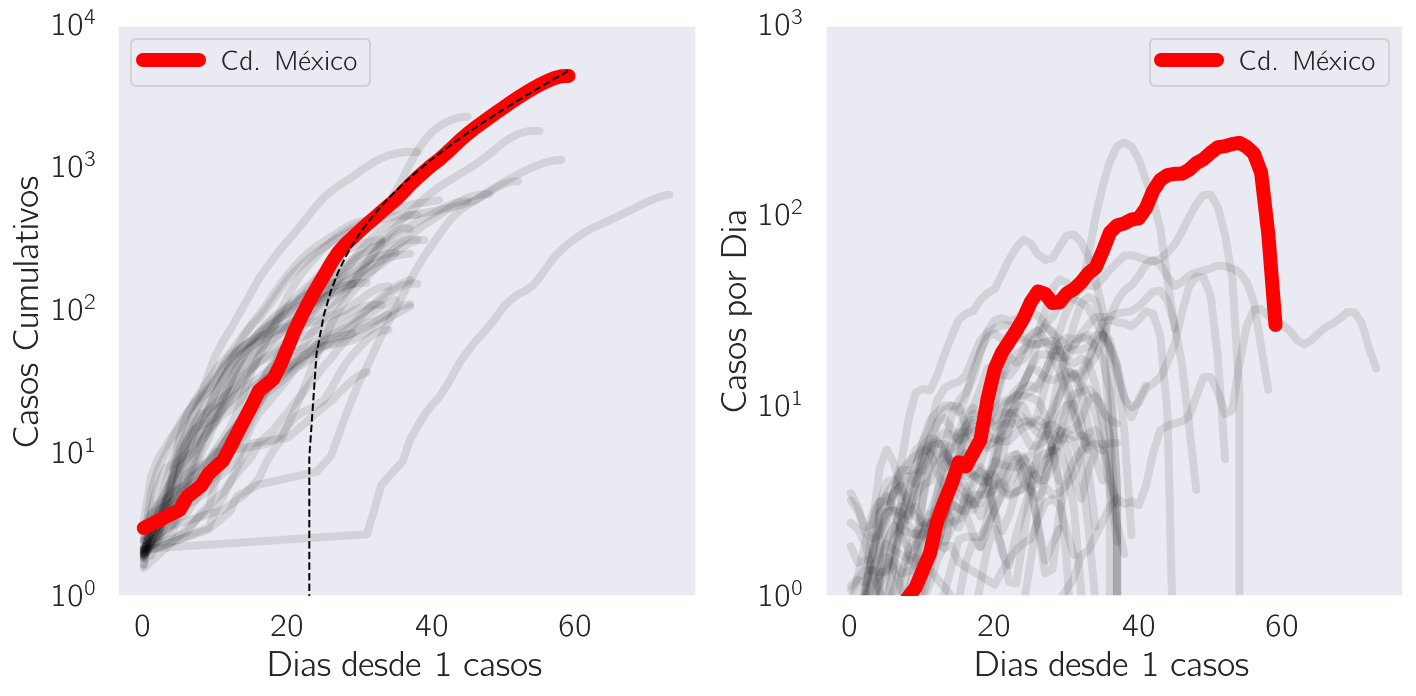

In [216]:
def growth(t, a, tau, b):
    """Exponential growth function."""
    return a * np.exp(t / tau) + b

def plot_mx(cumdf, ax, gradient=False, col='cases', cond = (cumdf.cases > 1)):
    for n, g in cumdf[cond].groupby('estado'):
        x = (g.fecha_de_inicio_de_sintomas - g.fecha_de_inicio_de_sintomas.min()) / dt.timedelta(days=1)

        if n == 'CIUDAD DE MÉXICO':
            color = 'red'
            alpha = 1
            label='Cd. México'
            s = 7
            zorder = np.inf
        else:
            color = 'black'
            alpha = 0.1
            label = '_'
            s = 4
            zorder = 0

        y = savgol_filter(g[col], 7, 3)
        if gradient:
            y = np.gradient(y, x)
        ax.plot(x, y, color=color, alpha=alpha, label=label, lw=s, zorder=zorder)

    ax.set_yscale('log')
    ax.set_xlabel('Dias desde 1 casos')
    ax.legend()
    return ax


fig, ax = plt.subplots(ncols=2, figsize=(10, 5))

ax[0] = plot_mx(cumdf, ax[0])

for n, g in cumdf[cumdf.cases > 1].groupby('estado'):
    if n != 'CIUDAD DE MÉXICO':
        continue
    
    x = (g.fecha_de_inicio_de_sintomas - g[g.cases > 100].fecha_de_inicio_de_sintomas.min()) / dt.timedelta(days=1)
    xr = (g.fecha_de_inicio_de_sintomas - g.fecha_de_inicio_de_sintomas.min()) / dt.timedelta(days=1)
    
    xp = (g[g.cases > 100].fecha_de_inicio_de_sintomas - g[g.cases > 100].fecha_de_inicio_de_sintomas.min()) / dt.timedelta(days=1)
    fit, covs = scipy.optimize.curve_fit(growth, xp, g[g.cases > 100].cases)
    
    a, tau, b = fit
    ax[0].plot(xr, growth(x, a, tau, b), ls='--', color='black', lw=1, zorder=np.inf)
    break

ax[0].set_ylabel('Casos Cumulativos')

ax[1] = plot_mx(cumdf, ax[1], 'identificacion')
ax[1].set_ylabel('Casos por Dia')

ax[0].set_ylim(1, 10 ** 4)
ax[1].set_ylim(1, 10 ** 3)
plt.tight_layout()

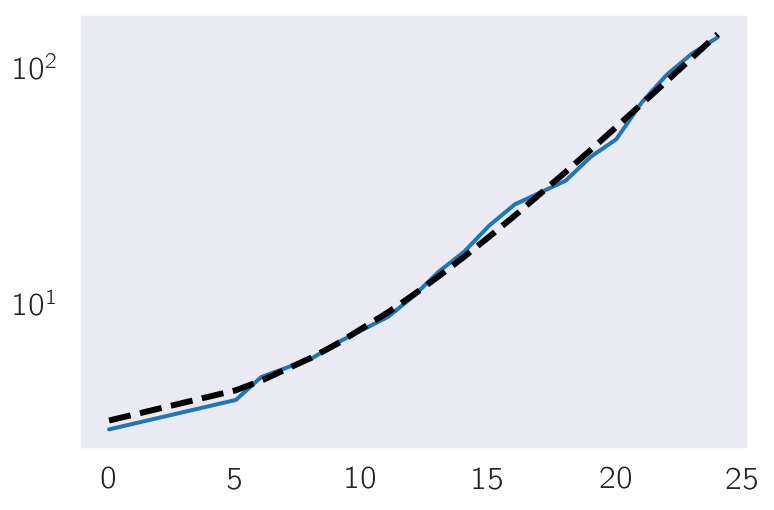

In [214]:
fig, ax = plt.subplots()
for n, g in cumdf[(cumdf.cases > 1) & (cumdf.cases < 150)].groupby('estado'):
    if n != 'CIUDAD DE MÉXICO':
        continue
    
    x = (g.fecha_de_inicio_de_sintomas - g.fecha_de_inicio_de_sintomas.min()) / dt.timedelta(days=1)
    fit, covs = scipy.optimize.curve_fit(growth, x, g.cases)
    a, tau, b = fit
    ax.plot(x, growth(x, a, tau, b), ls='--', color='black', lw=3, zorder=np.inf)
    ax.plot(x, g.cases)
    break

plt.yscale('symlog')